# Credit Card Approval Prediction with binary classifiers

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.

Data are obtained from the following source
https://www.kaggle.com/rikdifos/credit-card-approval-prediction

The data consists of two tables connected by ID.
*application_record.csv* contains appliers personal information, which you could use as features for predicting.
*credit_record.csv* records include users' credit card usage.
A detailed explanation can be found at https://www.kaggle.com/rikdifos/credit-card-approval-prediction/discussion/119320

In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
from sklearn import metrics,preprocessing # ,datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#from sklearn.compose import ColumnTransformer
#from sklearn.metrics import confusion_matrix
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import OneHotEncoder
pd.options.display.max_columns = None

from sklearn.metrics import mean_squared_error

In [24]:
# Read application data
application = pd.read_csv("application_record.csv")

# Peek data
application.head() # application_record.info()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [25]:
# Naming columns to be more descriptive
application.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Property',
                         'CNT_CHILDREN':'Children','AMT_INCOME_TOTAL':'Incomes',
                         'NAME_EDUCATION_TYPE':'Education','NAME_FAMILY_STATUS':'Marital',
                         'NAME_HOUSING_TYPE':'House','DAYS_BIRTH':'Age','DAYS_EMPLOYED':'WorkYears',
                         'FLAG_MOBIL':'PhoneMobile','FLAG_EMAIL':'Email',
                         'NAME_INCOME_TYPE':'Profession','FLAG_WORK_PHONE':'PhoneWork',
                         'FLAG_PHONE':'PhoneHome','CNT_FAM_MEMBERS':'Family',
                        'OCCUPATION_TYPE':'Occupation'
                        },inplace=True)
application.head()

,ID,Gender,Car,Property,Children,Incomes,Profession,Education,Marital,House,Age,WorkYears,PhoneMobile,PhoneWork,PhoneHome,Email,Occupation,Family
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [26]:
# Read credit data
credit = pd.read_csv("credit_record.csv")
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [27]:
# Naming columns to be more descriptive
credit.rename(columns={'MONTHS_BALANCE':'CreditMonths','STATUS':'Label'},inplace=True)
credit.head()

,ID,CreditMonths,Label
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


**Explanation of Label features:**

0: 1-29 days past due

1: 30-59 days past due

2: 60-89 days overdue

3: 90-119 days overdue

4: 120-149 days overdue

5: Overdue or bad debts, write-offs for more than 150 days

C: paid off that month

X: No loan for the month

In [28]:
# Classifying labels X,C,0,1,2 as creditworthy(0) and 3,4,5 unworthy(1) of credit
credit["Label"] = credit["Label"].replace(['X','C','0','1'],0).replace(['2','3','4','5'],1)

# Grouping credit data by ID and finding out max value of status
credit = credit.groupby(['ID']).agg({'CreditMonths': 'count','Label': 'max'})

#sum(credit_record['STATUS'] == 1) # Number of ones
credit.head(10)

,CreditMonths,Label
ID,,
5001711,4,0
5001712,19,0
5001713,22,0
5001714,15,0
5001715,60,0
5001717,22,0
5001718,39,0
5001719,43,0
5001720,36,0


In [29]:
# Merging records
X = pd.merge(application,credit, on = 'ID') # left_on = 'ID',right_on = 'ID'

# Check for duplicate records
X[X.duplicated()]

,ID,Gender,Car,Property,Children,Incomes,Profession,Education,Marital,House,Age,WorkYears,PhoneMobile,PhoneWork,PhoneHome,Email,Occupation,Family,CreditMonths,Label


In [30]:
# Creating target vector
y = X['Label']

# Dropping index and label
X.drop(['ID','Label'], axis=1,inplace = True)

X.head()
# Checking types of colums
#X.dtypes
#merged_records.info()

,Gender,Car,Property,Children,Incomes,Profession,Education,Marital,House,Age,WorkYears,PhoneMobile,PhoneWork,PhoneHome,Email,Occupation,Family,CreditMonths
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,16
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,30
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,5
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,5


In [31]:
# Find out the locations and numbers of NaNs
X.isnull().sum()

Gender              0
Car                 0
Property            0
Children            0
Incomes             0
Profession          0
Education           0
Marital             0
House               0
Age                 0
WorkYears           0
PhoneMobile         0
PhoneWork           0
PhoneHome           0
Email               0
Occupation      11323
Family              0
CreditMonths        0
dtype: int64

In [32]:
# Find out uniques occupation types
X.Occupation.unique()

array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

**More than 5 percent of data in column Occupation contains NaN. Statistically it's unwise to drop missing rows and too much data is lost if the entire column is dropped. It is also unlikely that the Profession can be predicted from given data. This time solution is to replace NaN with Unknown**

In [33]:
# Replace Occupation = NaN to Unknown
X = X.fillna('Unknown')

#Separate data to numerical and categorila values
numerical = X.select_dtypes(include=[np.number]).copy()
categorical = X.select_dtypes(exclude=[np.number]).copy()

#X.describe()
categorical


,Gender,Car,Property,Profession,Education,Marital,House,Occupation
0,M,Y,Y,Working,Higher education,Civil marriage,Rented apartment,Unknown
1,M,Y,Y,Working,Higher education,Civil marriage,Rented apartment,Unknown
2,M,Y,Y,Working,Secondary / secondary special,Married,House / apartment,Security staff
3,F,N,Y,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
4,F,N,Y,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
...,...,...,...,...,...,...,...,...
36452,M,Y,Y,Working,Secondary / secondary special,Married,House / apartment,Managers
36453,F,N,Y,Commercial associate,Higher education,Married,House / apartment,Medicine staff
36454,F,N,Y,Pensioner,Higher education,Married,House / apartment,Medicine staff
36455,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,Sales staff


# Analyzing Numerical Variables

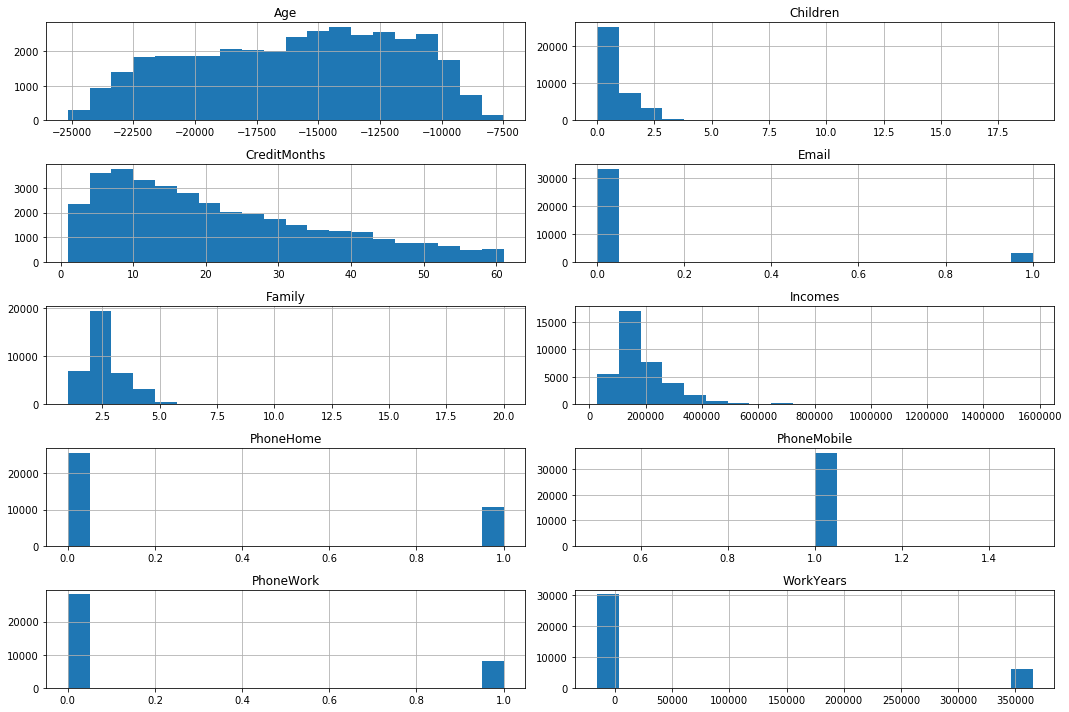

In [34]:
# Plotting histograms from numerical data
numerical.hist(bins=20, figsize=(15, 10), layout=(5, 2))
plt.tight_layout()

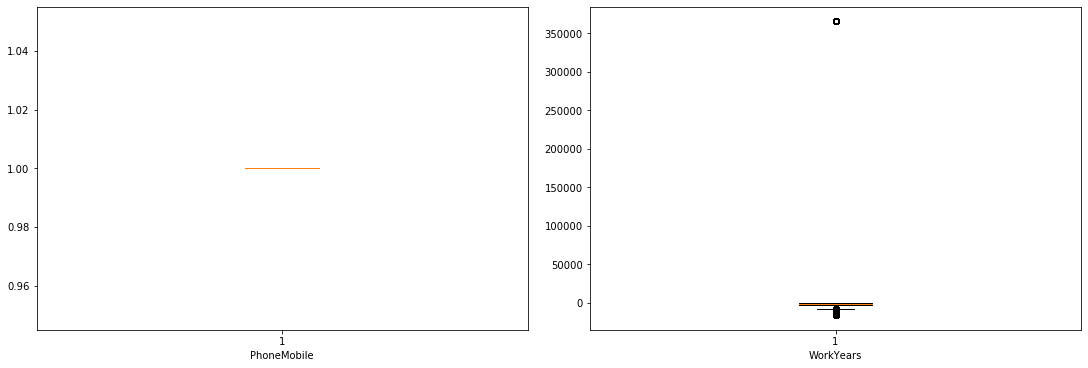

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5),constrained_layout=True)
#fig.suptitle('A tale of 2 subplots')

ax[0].boxplot(numerical['PhoneMobile'])
ax[0].set_xlabel('PhoneMobile')

ax[1].boxplot(numerical['WorkYears'])
ax[1].set_xlabel('WorkYears')

plt.show()

In [36]:
# Convert Age and WorkYears to years
X['WorkYears'] = X.WorkYears/-365
X['Age'] = X.Age/-365

# Replacing outliers WorkYears < -50 to 0
X["WorkYears"] = np.where((X['WorkYears'] < -50),0,X['WorkYears'])

# Convert Family column to int type
X['Family'] = X['Family'].astype('int')

# Checking PhoneMobile values
X.PhoneMobile.value_counts()

1    36457
Name: PhoneMobile, dtype: int64

**All the rows in PhoneMobile column are 1:s. Because it has no variation it won't add any value to the model. Hence it can be dropped**

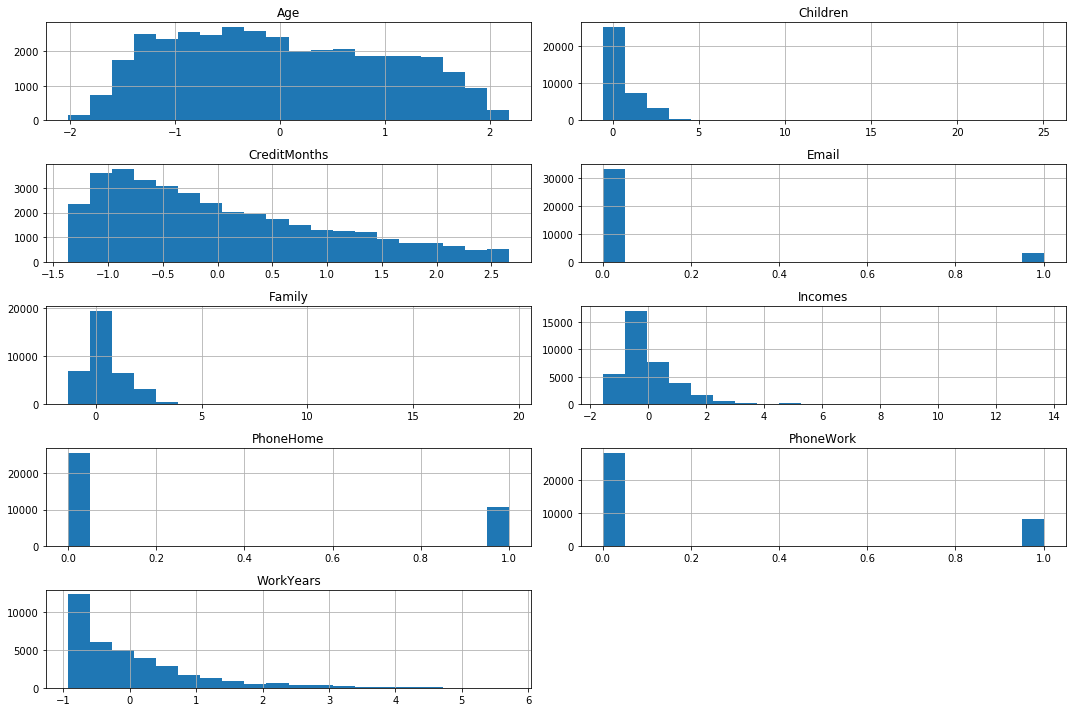

In [37]:
# Dropping PhoneMobile column
X.drop(['PhoneMobile'], axis=1,inplace = True)

# Choosing features to scale
features = ['Incomes','WorkYears','Age','CreditMonths','Family','Children']

# Creating scaler
scaler = preprocessing.StandardScaler() # MinMaxScaler()

# Transforming the features
X[features] = scaler.fit_transform(X[features])

X.hist(bins=20, figsize=(15, 10), layout=(5, 2))
plt.tight_layout()

# Analyzing Categorical Variables

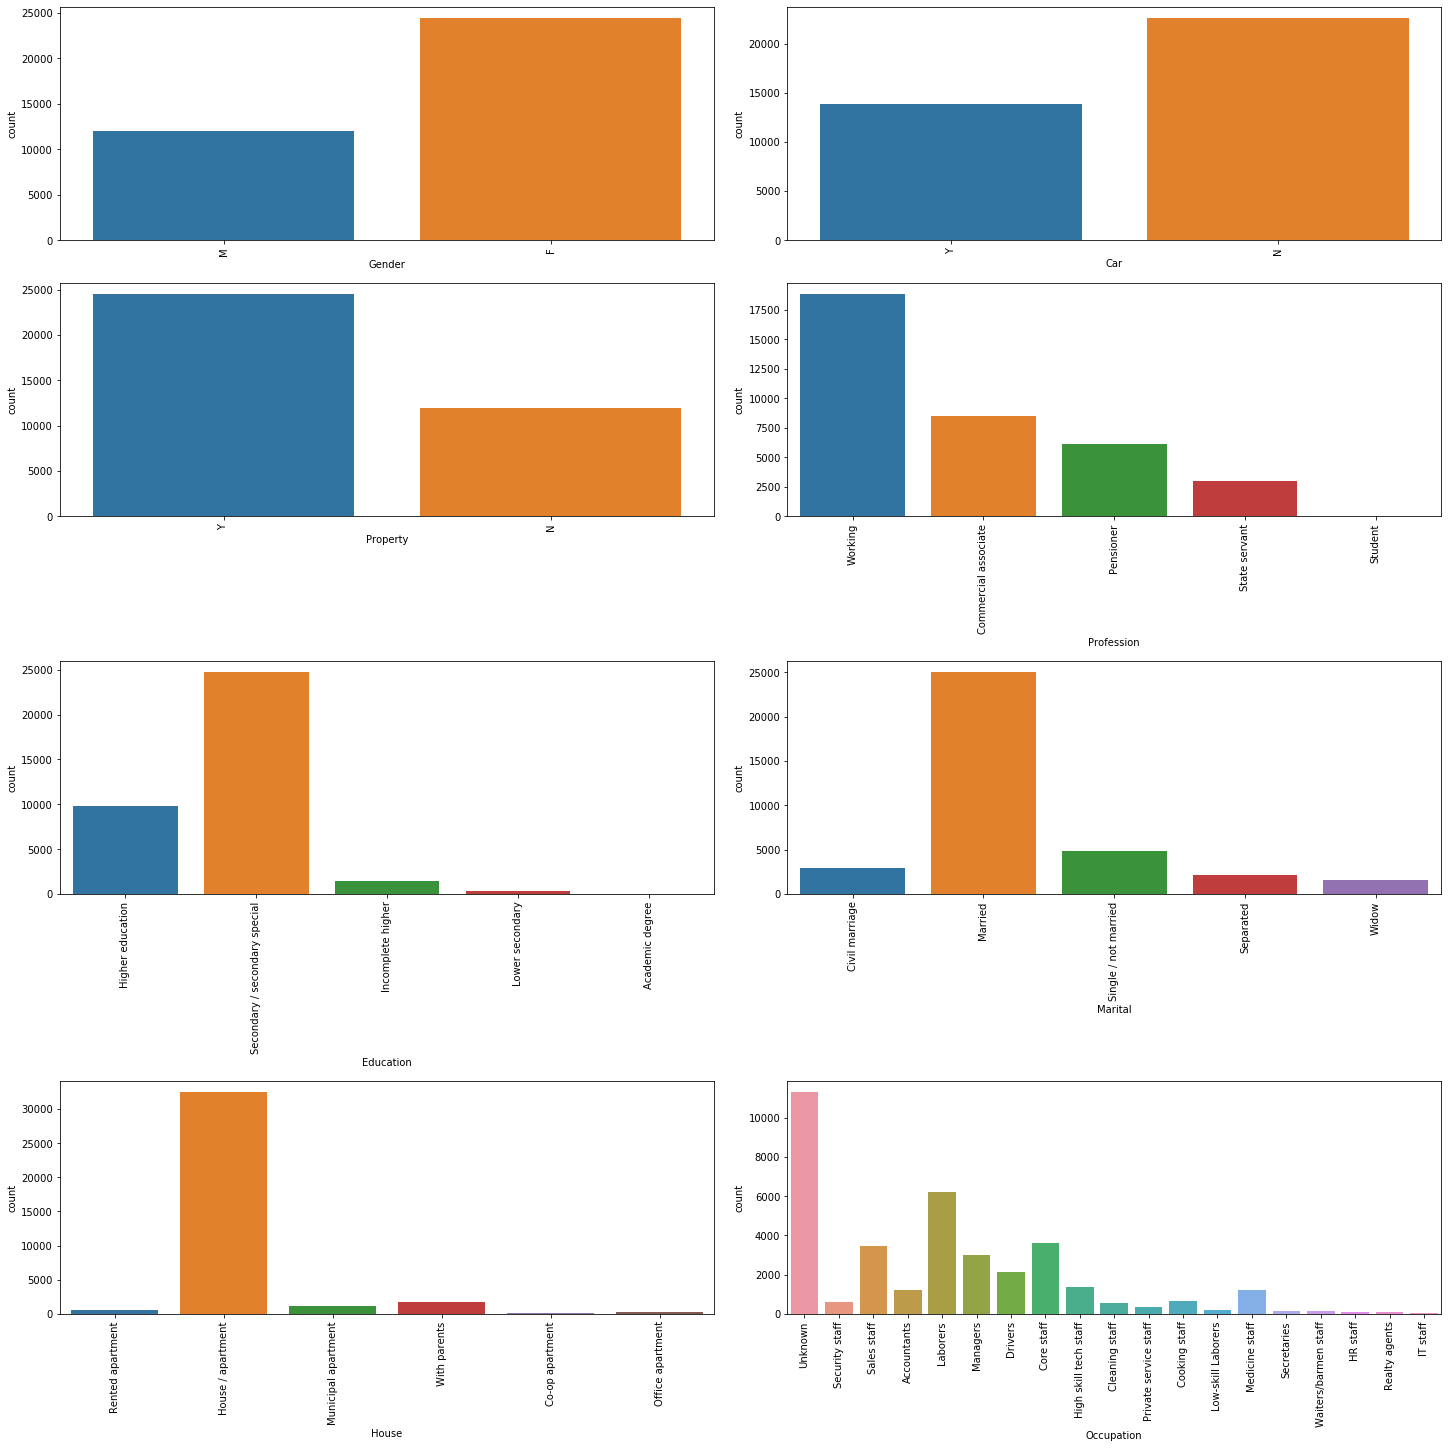

In [38]:
# Plotting bar plots from catecorial data
fig, ax = plt.subplots(4, 2, figsize=(20, 20),constrained_layout=True)
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(X[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [39]:
X = pd.get_dummies(X,drop_first=True)
X.head()

,Children,Incomes,Age,WorkYears,PhoneWork,PhoneHome,Email,Family,CreditMonths,Gender_M,Car_Y,Property_Y,Profession_Pensioner,Profession_State servant,Profession_Student,Profession_Working,Education_Higher education,Education_Incomplete higher,Education_Lower secondary,Education_Secondary / secondary special,Marital_Married,Marital_Separated,Marital_Single / not married,Marital_Widow,House_House / apartment,House_Municipal apartment,House_Office apartment,House_Rented apartment,House_With parents,Occupation_Cleaning staff,Occupation_Cooking staff,Occupation_Core staff,Occupation_Drivers,Occupation_HR staff,Occupation_High skill tech staff,Occupation_IT staff,Occupation_Laborers,Occupation_Low-skill Laborers,Occupation_Managers,Occupation_Medicine staff,Occupation_Private service staff,Occupation_Realty agents,Occupation_Sales staff,Occupation_Secretaries,Occupation_Security staff,Occupation_Unknown,Occupation_Waiters/barmen staff
0,-0.579661,2.365845,-0.945169,0.989403,1,0,0,-0.217680,-0.357599,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-0.579661,2.365845,-0.945169,0.989403,1,0,0,-0.217680,-0.424661,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-0.579661,-0.728827,1.309091,-0.450538,0,0,0,-0.217680,0.581264,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,-0.579661,0.818509,0.746300,0.359429,0,1,1,-1.314564,-1.095278,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,-0.579661,0.818509,0.746300,0.359429,0,1,1,-1.314564,-1.095278,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [40]:
# Create correlation to find out correlation between variables
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                          k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
X.drop(X.columns[to_drop], axis=1)

,Children,Incomes,Age,WorkYears,PhoneWork,PhoneHome,Email,Family,CreditMonths,Gender_M,Car_Y,Property_Y,Profession_Pensioner,Profession_State servant,Profession_Student,Profession_Working,Education_Higher education,Education_Incomplete higher,Education_Lower secondary,Education_Secondary / secondary special,Marital_Married,Marital_Separated,Marital_Single / not married,Marital_Widow,House_House / apartment,House_Municipal apartment,House_Office apartment,House_Rented apartment,House_With parents,Occupation_Cleaning staff,Occupation_Cooking staff,Occupation_Core staff,Occupation_Drivers,Occupation_HR staff,Occupation_High skill tech staff,Occupation_IT staff,Occupation_Laborers,Occupation_Low-skill Laborers,Occupation_Managers,Occupation_Medicine staff,Occupation_Private service staff,Occupation_Realty agents,Occupation_Sales staff,Occupation_Secretaries,Occupation_Security staff,Occupation_Unknown,Occupation_Waiters/barmen staff
0,-0.579661,2.365845,-0.945169,0.989403,1,0,0,-0.217680,-0.357599,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-0.579661,2.365845,-0.945169,0.989403,1,0,0,-0.217680,-0.424661,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-0.579661,-0.728827,1.309091,-0.450538,0,0,0,-0.217680,0.581264,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,-0.579661,0.818509,0.746300,0.359429,0,1,1,-1.314564,-1.095278,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,-0.579661,0.818509,0.746300,0.359429,0,1,1,-1.314564,-1.095278,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,-0.579661,1.260605,0.326825,0.092820,0,0,0,-0.217680,-0.625846,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
36453,-0.579661,-0.286731,-0.854227,-0.369837,0,1,1,-0.217680,0.178894,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
36454,-0.579661,-0.286731,-0.854227,-0.369837,0,1,1,-0.217680,0.782449,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
36455,-0.579661,0.951138,0.472046,-0.652924,0,0,0,-0.217680,-0.759969,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


**There are no signicant correlation between variables so no need reduce features.**

# Classification

In [41]:
# Show counts of label y
#y.value_counts() #np.bincount(y)
unique_elements, counts_elements = np.unique(y, return_counts=True)
print("Frequency of unique values of the array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the array:
[[    0     1]
 [35841   616]]


**Label y is highly unbalanced. It will be balanced by classifier's hyperparameter class_weight="balanced"**

In [42]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
#X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,:13], y, train_size=0.8, test_size=0.2)

# Naive Bayes

Naive Bayes algorithms are supervised learning methods based on applying Bayes’ theorem with strong (naive) feature independence assumptions.

In [43]:
# Create an instance of Naive Bayes Classifier and fit the data.
model = GaussianNB()
model.fit(X_train, y_train)

# Get the predicted labels for X
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# compute training error
err_train = mean_squared_error(y_train, y_train_pred) 

# compute validating error
err_val_NB = mean_squared_error(y_test, y_test_pred) 

print(f"NB training error: {round(err_train, 3)}")
print(f"NB validating error: {round(err_val_NB, 3)}")

NB training error: 0.911
NB validating error: 0.915


# Logistic regression classifier

Logistic Regression is a mathematical model used in statistics to estimate the probability of an event occurring having been given some previous data. Logistic Regression works with binary data, where either the event happens (1) or the event does not happen (0).

In [44]:
# Create an instance of Logistic Regression Classifier and fit the data.
model = LogisticRegression(random_state=0, class_weight="balanced")
model.fit(X_train, y_train)

# Get the predicted labels for X
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# compute training error
err_train = mean_squared_error(y_train, y_train_pred) 

# compute validating error
err_val_lr = mean_squared_error(y_test, y_test_pred) 

print(f"Logistic regression training error: {round(err_train, 3)}")
print(f"Logistic validating error: {round(err_val_lr, 3)}")

Logistic regression training error: 0.291
Logistic validating error: 0.298


# Decision tree classifier

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [45]:
# Create an instance of Decision Tree Classifier and fit the data.
model = DecisionTreeClassifier(random_state=0, class_weight="balanced")   
model.fit(X_train, y_train)     

# Get the predicted labels for X
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# compute training error
err_train = mean_squared_error(y_train, y_train_pred) 

# compute validating error
err_val_dt = mean_squared_error(y_test, y_test_pred) 

print(f"Decision Trees training error: {round(err_train, 3)}")
print(f"Decision Trees validating error: {round(err_val_dt, 3)}")

Decision Trees training error: 0.001
Decision Trees validating error: 0.025


# Random forest classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [46]:
# Create an instance of Random Forest Classifier and fit the data.
model = RandomForestClassifier(random_state=0, class_weight="balanced" )
model.fit(X_train, y_train)

# Get the predicted labels for X
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# compute training error
err_train = mean_squared_error(y_train, y_train_pred) 

# compute validating error
err_val_rf = mean_squared_error(y_test, y_test_pred) 

print(f"Random forests training error: {round(err_train, 3)}")
print(f"Random forest validating error: {round(err_val_rf, 3)}")

# # Get the predicted labels for X,
# y_pred = model.predict(X_test)

# # Calculate the accuracy of the predictions
# accuracy4 = metrics.accuracy_score(y_pred, y_test)
# print(f"Accuracy of classification: {round(100*accuracy4, 2)}%")

Random forests training error: 0.001
Random forest validating error: 0.018


# Results

Classifications were done by default hyperparameter without tuning. Naive Bayes was the worst as expected. It always performs poorly when there are more than fifteen features, and it was included to get a benchmark for other models. Unfortunately it has not class_weight-hyperparameter so result are not comparable to other classifiers.Random forest classification has the smallest validation error, so it is the recommended method. 

Based on the application data, the bank can reliably decide to issue a credit card to the applicant. And similarly, credit card information can be used in part to grant a bank loan. 

In [47]:
print(f"Validating error of Naive Bayes classification: {round(err_val_NB, 3)}")
print(f"Validating error of Logistic regression classification: {round(err_val_lr, 3)}")
print(f"Validating error of Decission tree classification: {round(err_val_dt, 3)}")
print(f"Validating error of Random forest classification: {round(err_val_rf, 3)}")
# print(f"Accuracy of Random forest classification: {round(100*accuracy4, 2)}%")

Validating error of Naive Bayes classification: 0.915
Validating error of Logistic regression classification: 0.298
Validating error of Decission tree classification: 0.025
Validating error of Random forest classification: 0.018
